Epoch 1/100


c:\Users\punna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5032 - loss: 1.3143 - val_accuracy: 0.6650 - val_loss: 0.6905
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5133 - loss: 1.0078 - val_accuracy: 0.6447 - val_loss: 0.6884
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5604 - loss: 0.8325 - val_accuracy: 0.6497 - val_loss: 0.6866
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6023 - loss: 0.6970 - val_accuracy: 0.7107 - val_loss: 0.6842
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6595 - loss: 0.6203 - val_accuracy: 0.8173 - val_loss: 0.6809
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7116 - loss: 0.5790 - val_accuracy: 0.8528 - val_loss: 0.6778
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7459 - loss: 0.5315 - val_accuracy: 0.8832 - val_loss: 0.6750
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7713 - loss: 0.4951 - val_accuracy: 0.8985 - val_loss: 0.6723

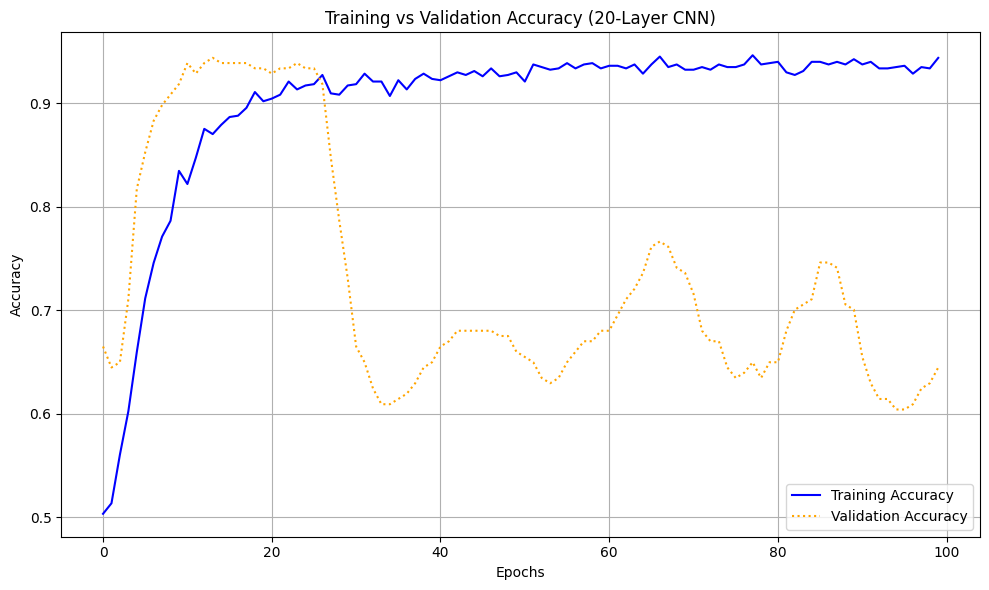

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization, ReLU
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('creditcard.csv')

# Balance the dataset by undersampling the majority class
fraud = data[data['Class'] == 1]
non_fraud = data[data['Class'] == 0].sample(len(fraud), random_state=42)
balanced_data = pd.concat([fraud, non_fraud])

# Separate features and target
X = balanced_data.drop(['Class'], axis=1)
y = balanced_data['Class']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape input for Conv1D: (samples, timesteps, features)
X_scaled = np.expand_dims(X_scaled, axis=2)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the 20-layer CNN model
model = Sequential([
    Conv1D(32, kernel_size=2, input_shape=(X_train.shape[1], 1)),
    ReLU(),
    BatchNormalization(),
    Dropout(0.2),
    Conv1D(64, kernel_size=2),
    ReLU(),
    BatchNormalization(),
    Dropout(0.5),
    Conv1D(64, kernel_size=2),
    ReLU(),
    BatchNormalization(),
    Dropout(0.5),
    Conv1D(64, kernel_size=2),
    ReLU(),
    BatchNormalization(),
    Dropout(0.25),
    Flatten(),
    Dense(100),
    ReLU(),
    Dropout(0.5),
    Dense(50),
    ReLU(),
    Dense(25),
    ReLU(),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=2048, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
auc = roc_auc_score(y_test, y_pred_prob)
prc_precision, prc_recall, _ = precision_recall_curve(y_test, y_pred_prob)

# Print Metrics
print("20-Layer Model Metrics (Balanced Dataset):")
print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Confusion Matrix: {cm}")
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Total Fraudulent Transactions in Test Set: {sum(y_test)}")

# Plot Training vs Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', linestyle='-', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle=':', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (20-Layer CNN)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()